In [1]:
#import tweepy library
import tweepy
import json 
from collections import Counter
import os
import pickle
import twitter
import pandas as pd
import ipywidgets as widget
from IPython.display import display, clear_output
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
import matplotlib.pyplot as plt
from tweepy import Stream
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import time
from wordcloud import WordCloud, STOPWORDS

#declare and assign values to authorization variables
ConsumerKey = "e8yOMk1PYebFI6IqAmJPac9sY"
ConsumerSecret = "ghdd9BjIIkmIp9rHahIUrj6cLdMzMX35m8xRuDc19D7s4BOVHD"
AccessToken = "3770751192-URKr3kja687MI8HvZ6KcvwvfXEmup0YE9Cc7tyb"
AccessTokenSecret = "2TjrhbSiXOroOQVzWoMQ5ArB2ehIasUJ06hJmBBG9LzCX"
BearerToken = "AAAAAAAAAAAAAAAAAAAAADuIOwEAAAAAsOVffQU%2BTcjto0yCqpjKsjRSYq8%3DrSpogsdTnGTLgPWOxU5tmHvwf3X9n8gsEWLsHLxcy1QACmRlud"

#twitter authorization started
auth = tweepy.OAuthHandler(ConsumerKey, ConsumerSecret)
auth.set_access_token(AccessToken, AccessTokenSecret)

In [2]:
#define a function to return API authorization
def APIAuthorization():
    api = tweepy.API(auth)
    return api

In [3]:
#define a variable that can directly be used to get data from twitter API
exractor = APIAuthorization()

In [4]:
#Q1: twitter realtime stream data fetching and injecting into local system file = realtimeStreamData.json, and showing top 10 results
class TwitterStreamer():
    def __init__(self):
        pass
    
    def StrimTweets(self, fetchedTweetFileName, hashTagList):
        listener = StdOutListener(fetchedTweetFileName)
        stream = Stream(auth, listener)
        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hashTagList)
        print(stream)
    
#a class to to write the stram data to file
class StdOutListener(StreamListener):
    def __init__(self, fetchedTweetFileName):
        self.fetchedTweetFileName = fetchedTweetFileName

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetchedTweetFileName, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        print(status)
 
fetchedTweetFileName = "realtimeStreamData.json"
hashTagList = ["donal trump", "hillary clinton", "barack obama", "bernie sanders"]
 
#spark intialization
spark = SparkSession.builder.appName("PysparkExample") \
            .config ("spark.sql.shuffle.partitions", "50") \
            .config("spark.driver.maxResultSize","5g") \
            .config ("spark.sql.execution.arrow.enabled", "true") \
            .getOrCreate()

dataFrameJson = spark.read.json('realtimeStreamData.json')
dataFrameJson.show(10)



+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+-------------+----------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quote_count|quoted_status|quoted_stat

In [5]:
#Q2: function to dump 50 trending topics (incuding topics) worldwide and print as per choosen from dropdown using pyspark          
btnSearch = widget.Button(
    description = "Search"
)


dropDownSelectNumber = widget.Dropdown(
    options=[('Ten', 10), ('Thirty', 30), ('Fifty', 50)],
    value=10,
    description='Number:',
)

dropDownSelectMinutes = widget.Dropdown(
    options=[('Ten Minutes', 10), ('Thirty Minutes', 30), ('Sixty Minutes', 60)],
    value=10,
    description='Last Minutes:',
)


WOE_ID = 1 #1=worldwide
def PrintTweets():
    clear_output()
    trends = exractor.trends_place(WOE_ID)
    #print(trends)
    trends = json.loads(json.dumps(trends, indent=1))
    trending = []
    for trend in trends[0]["trends"]:
        trending.append(trend["name"])
    trending
    data1= pd.DataFrame(trending,columns= ['Trends'])
    data1.to_csv('trendingTopics.csv')
    print()
    dataFrameJson = _spark.read.csv('trendingTopics.csv', header=True)
    dataFrameJson.show(_dropDownSelectNumber.value)
    
    
#define button click function
def TweetsByNumberAndMinutes(b):
    with outputDisplay:
        PrintTweets()
        
   

btnSearch.on_click(TweetsByNumberAndMinutes) 

outputDisplay = widget.Output()

items = [dropDownSelectNumber, dropDownSelectMinutes, btnSearch]
indx = widget.HBox([items[0], items[1], items[2]])
widget.VBox([indx, outputDisplay])




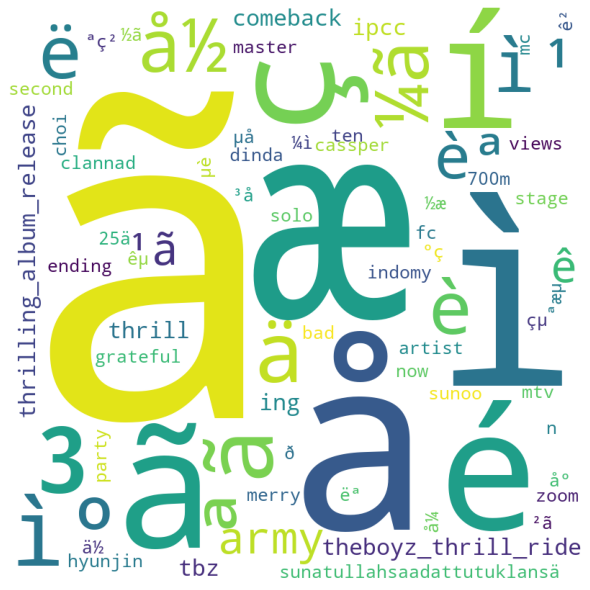

In [6]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dataFrame = pd.read_csv(r"trendingTopics.csv", encoding ="latin-1") 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
 
for val in dataFrame.Trends: 
 
    val = str(val) 

    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()



In [11]:
#Q3: top trending tweets
if not os.path.exists('secret_twitter_credentials.pk1'):
    Twitter = {}
    Twitter['Consumer Key'] = '2xd78q4oIIuQz2MrRx126cOq3'
    Twitter['Consumer Secret'] = 'Th2OuF7kXOsqGMvjSBDIfwIN59YXYJfd7oiuXmw9Zxsd2I8yN5'
    Twitter['Access Token'] = '462777940-0HfcULFaQtNfgZWfQbQC1UlgVLp6u2SR4GafWqzu'
    Twitter['Access Token Secret'] = '2OD0S1GS49q80YPStEcKa4ESCHmANQ2tZUBTGe9mcwYL7'
    with open('hashtags.csv','wb') as f:
        pickle.dump(Twitter,f)
else:
    Twitter = pickle.load(open('hashtags.csv','rb'))
    
auth = twitter.oauth.OAuth(Twitter['Access Token'],
                          Twitter['Access Token Secret'],
                          Twitter['Consumer Key'],
                          Twitter['Consumer Secret'])
twitterAPI = twitter.Twitter(auth=auth)
print(twitterAPI)

topic = input("Enter #topic_name: ")
number = 1000
searchResults = twitterAPI.search.tweets(q=topic, count=number)
statuses = searchResults['statuses'] 
len(statuses)   
allText =[]
filteredStatuses=[]
for s in statuses:
    if not s['text'] in allText:
        filteredStatuses.append(s)
        allText.append(s["text"])
statuses= filteredStatuses
len(statuses)
print(json.dumps(statuses[0], indent=1))
t = statuses[0]
print(t['retweet_count'])
print(t['retweeted'])
statusTexts = [status['text']
               for status in statuses]
screenNames = [user_mention['screen_name']
               for status in statuses
                   for user_mention in status['entities']['user_mentions']]
hashtags = [hashtag['text']
               for status in statuses
                   for hashtag in status['entities']['hashtags']]

#compute the collection of the words from all tweets
words = [w
        for t in statusTexts

         for w in t.split()]
print(json.dumps(statusTexts[:5],indent=1))
print(json.dumps(screenNames[:5],indent=1))
print(json.dumps(hashtags[:5],indent=1))
print(json.dumps(words[:5],indent=1))

for item in [words, screenNames, hashtags]:
    c=Counter(item)
    print(c.most_common()[:100]) 
    print() 

def prettyprint_counts(label,list_of_tuples):
    print("\n{:^20} | {:^6}".format(label,"Count"))
    print("*"*40)
    for k,v in list_of_tuples:
        print("{:20} | {:>6}".format(k,v))   
for label, data3 in (('word', words),
                   ('Screen Name', screenNames),
                   ('Hashtag', hashtags)):
    c = Counter(data3)
    prettyprint_counts(label,c.most_common()[:10])  

retweets = [
            (status['retweet_count'],
             status['retweeted_status']['user']['screen_name'],
             status['text'].replace("\n","\\"))
    
             for status in statuses
                if 'retweeted_status' in status
          ]  
row_template = "{:^7} | {:^15} | {:50}"
def prettyprint_tweets(list_of_tuples):
    print()
    print(row_template.format("Likes","Screen Name","Text"))
    print("*"*30)
    for count, screenNames, text in list_of_tuples:
        print(row_template.format(count, screenNames,text[:50]))

        if len(text)>50:
            print(row_template.format("","",text[50:100]))
            if len(text)>100:
                print(row_template.format("","",text[100:])) 

prettyprint_tweets(sorted(retweets, reverse=True)[:100])
data8= pd.DataFrame(screenNames, columns= ['screenNames'])
data8.to_csv('ScreenName.csv')

Enter #topic_name: test
{
 "created_at": "Mon Aug 09 10:28:49 +0000 2021",
 "id": 1424679048995762182,
 "id_str": "1424679048995762182",
 "text": "RT @LesStonehouse: NSW hasn't introduced a payment for people to stay home while they wait for test results?\n\nVictoria introduced a $450 pa\u2026",
 "truncated": false,
 "entities": {
  "hashtags": [],
  "symbols": [],
  "user_mentions": [
   {
    "screen_name": "LesStonehouse",
    "name": "Politic@l Spinner. \ud83d\ude12",
    "id": 1108565574,
    "id_str": "1108565574",
    "indices": [
     3,
     17
    ]
   }
  ],
  "urls": []
 },
 "metadata": {
  "iso_language_code": "en",
  "result_type": "recent"
 },
 "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>",
 "in_reply_to_status_id": null,
 "in_reply_to_status_id_str": null,
 "in_reply_to_user_id": null,
 "in_reply_to_user_id_str": null,
 "in_reply_to_screen_name": null,
 "user": {
  "id": 24512711,
  "id_str": "24512711",
  "name": "be

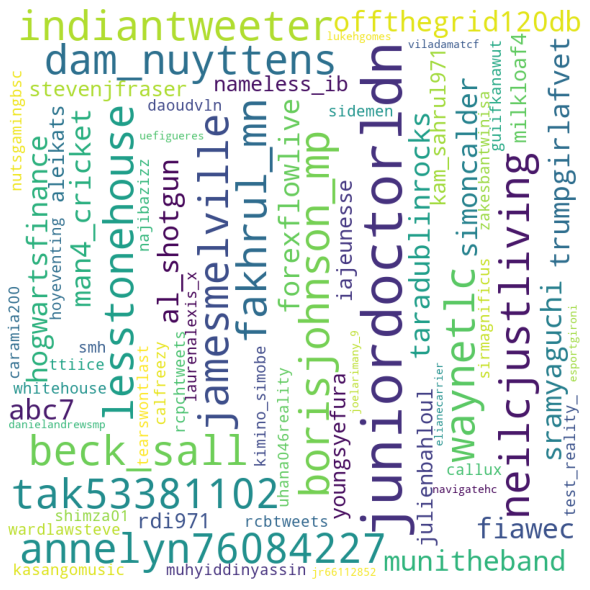

In [12]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
df6 = pd.read_csv(r"ScreenName.csv", encoding ="latin-1") 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df6.screenNames: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()